# Emukit Bayesian optimization Benchmark

This notebook compares two Bayesian optimization methods against each other, using the Branin test function.

In [1]:
import emukit
import numpy as np

## Set up test function

We use the Branin function which is already included in Emukit, both the function and the appropriate input domain are ready made for us.

In [2]:
from emukit.test_functions.branin import branin_function
branin_fcn, parameter_space = branin_function()

## Set up methods to test

We compare Bayesian optimization using different models. All the methods collect points one at a time in a sequential fashion and use the expected improvement acquisition function. The models we test are:
- A Gaussian process with Matern52 covariance function
- Random forest using the pyrfr package

We choose to create lambda functions with a consistent interface that return an instance of a loop with a given initial data set.

In [3]:
from emukit.examples.enums import ModelType, AcquisitionType
from emukit.examples.optimization_loops import create_bayesian_optimization_loop
from emukit.examples.single_objective_bayesian_optimization import GPBayesianOptimization

loops = [
    lambda x, y: create_bayesian_optimization_loop(x, y, parameter_space, AcquisitionType.EI, ModelType.RandomForest),
    lambda x, y: GPBayesianOptimization(parameter_space.parameters, x, y, acquisition_type=AcquisitionType.EI,
                                       noiseless=True)
]

# Run benchmark

A total of 100 initial data sets are generated of 5 observations that are randomly sampled from the input domain. For every intial data set, each method is run for 50 optimization iterations. The Gaussian process model has its hyper-parameters optimized after each function observation whereas the other models have fixed hyper-parameters.

In [5]:
from emukit.experimental_design.model_free.random_design import RandomDesign
random_design = RandomDesign(parameter_space)
n_restarts = 100
n_initial_data = 5
n_iterations = 50

minimum = np.zeros((len(loops), n_restarts, n_iterations))
for i in range(n_restarts):
    if i % 10 == 0:
        print('Restart number: ' + str(i+1))
    x = random_design.get_samples(n_initial_data)
    y = branin_fcn(x)
    for j, loop_fcn in enumerate(loops):
        loop = loop_fcn(x, y)
        loop.run_loop(branin_fcn, n_iterations)
        minimum[j, i, :] = np.minimum.accumulate(loop.loop_state.Y[:, 0])[n_initial_data:]

Restart number: 1
Restart number: 11
Restart number: 21
Restart number: 31
Restart number: 41
Restart number: 51
Restart number: 61
Restart number: 71
Restart number: 81
Restart number: 91


# Plot results

Plot the results of each method against each other. The plot shows the average value and standard deviation of the lowest observed value up to the given iteration.

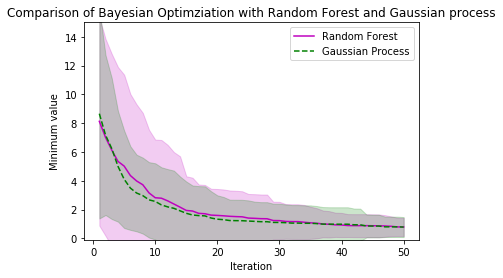

In [6]:
import matplotlib.pyplot as plt
avg_min = minimum.mean(axis=1)
std_min = minimum.std(axis=1)
iterations = np.arange(1, n_iterations+1)
plt.figure()
plt.plot(iterations, avg_min[0, :], 'm')
plt.fill_between(iterations, avg_min[0, :] - std_min[0, :], avg_min[0, :] + std_min[0, :], alpha=0.2, color='m')
plt.plot(iterations, avg_min[1, :], 'g', linestyle='--')
plt.fill_between(iterations, avg_min[1, :] - std_min[1, :], avg_min[1, :] + std_min[1, :], alpha=0.2, color='g')
plt.legend(['Random Forest', 'Gaussian Process'])
plt.ylim(-0.1, 15)

plt.xlabel('Iteration')
plt.ylabel('Minimum value')
plt.title('Comparison of Bayesian Optimziation with Random Forest and Gaussian process');

# Conclusion

We have shown how to use Emukit to benchmark different methods against each other for Bayesian optimziation. This methodology can easily be expanded to more loops using different models and acquisition functions.